# 9. 회귀 실습 - 자전거 대여 수요 예측
#### https://www.kaggle.com/c/bike-sharing-demand/data
#### 해당 데이터 세트는 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반하여 1시간 간격 동안의 자전거 대여 횟수가 있다. 결정 값은 마지막 칼럼인 count로 대여 횟수를 의미한다.
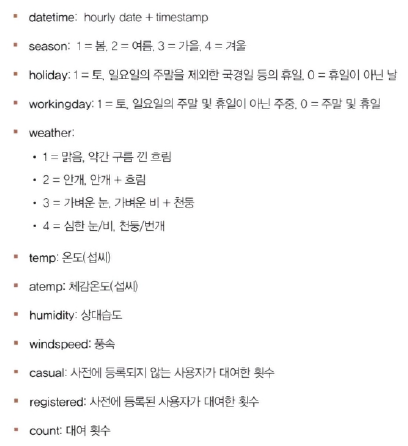

## 데이터 클렌징 및 가공과 데이터 시각화

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('C:\machine_learning_guide\DATA\\bike-sharing-demand\\bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [29]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


#### datetime 칼럼이 object이기 때문에 가공이 필요하다
#### datetime을 년, 월, 일, 시간으로 편리하게 변환하기 위해서 'datetime' 타입으로 변경하고 년, 월, 일 ,시간 칼럼으로 추출하자.

In [30]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


#### 기존 datetime 칼럼은 삭제하고, 컬럼들 중에서 casual, registered 칼럼은 count와 다중 공선성이 발생할 수 있어서 예측을 저해할 수 있어서 두 칼럼을 삭제한다.
#### casual + registered = count

In [31]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [32]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


#### 시간과 날짜에 해당하는 칼럼들에 대해서 count 가 어떻게 분포되어 있는지 시각화를 진행한다.

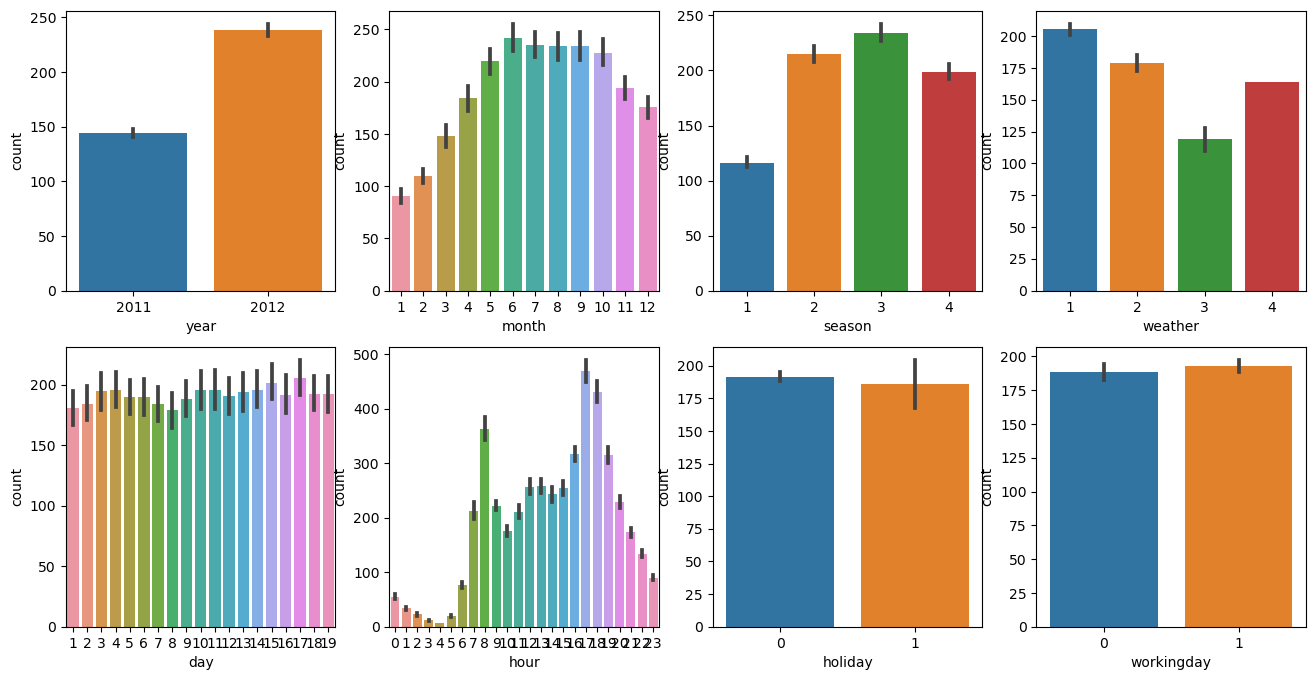

In [33]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 평균값을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

#### 분석
#### 1. year : 2012 > 2011 - 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가했다 ? (연도에 대한 데이터가 더 필요하다)
#### 2. month : 1, 2, 3 월은 대여량은 낮고, 6, 7,8 월의 대여량을 높다
#### 3. season : 봄(1), 겨울(4)이 낮고, 2(여름), 3(가을)이 높다
#### 4. weather : 눈 또는 비가 있는 경우(3과4), 맑거나(1) 약간 안개가 있는 경우(2)가 높다
#### 5. hour : 오전 출근 시간(8)과 오후 퇴근 시간(17, 18)이 상대적으로 높다.

#### 캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)인데, 사이킷런은 RMSLE를 제공하지 않아서 성능 평가 함수를 만들어 보자

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

#### log() 보다는 log1p를 이용하는데, log()의 경우에 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉽다. 그래서 1 + log() 는 그런 문제를 해결해준다. 그리고 log1p()로 변환된 값은 다시 넘파이의 expm1() 함수로 복원될 수 있다.

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


#### 실제 Target 데이터 값인 count를 감안하면 예측 오류가 큰 값이다.
#### 실제 값과 예측 값이 어느 정도 차이가 나는지 오류 값이 큰 순으로 5개만 확인해보자

In [38]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


#### 예측 오류 값이 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포를 확인해보자
#### Target 값의 분포는 정규 분포 형태가 가장 좋다.

<Axes: >

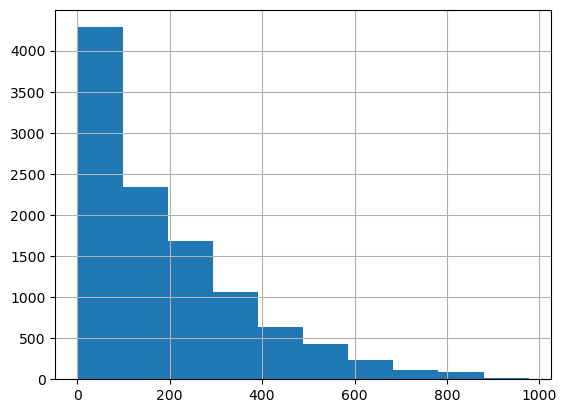

In [39]:
y_target.hist()

#### count 타겟 값이 정규 분포가 아닌 0~200 사이에 왜곡되어 있다.
#### 가장 일반적인 방법은 로그를 적용해 변환하는 것이다. (log1p())

<Axes: >

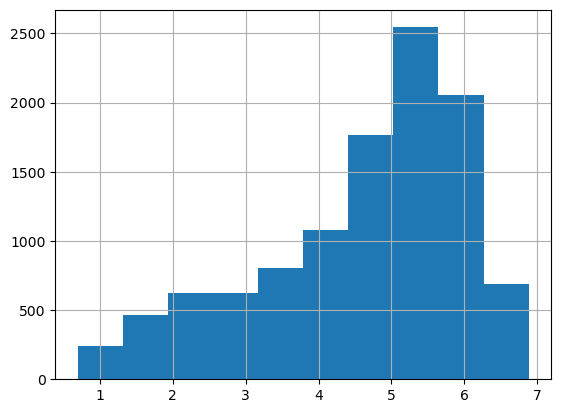

In [40]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

#### 완전한 정규 분포 형태는 아니지만 왜곡 정도가 많이 개선되었다! 다시 학습한 후 평가를 진행해보자

In [42]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


#### RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다.
#### 이번에는 개별 피처들에 인코딩을 적용할 것이다. 먼저 각 피처의 회귀 계수값을 시각화해보자

<Axes: >

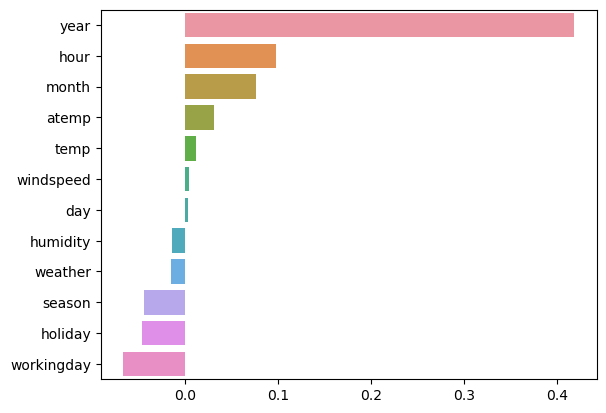

In [43]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

#### 숫자 값 형태의 피처들이 회귀 계수 영향도가 상대적으로 높다 -> 변환 필요
#### year는 2011, 2012 값이고 month는 1,2,3,4,5 ... 같은 숫자 값 형태로 의미를 담고 있는데, 개별 숫자값의 크기가 의미가 있는건 아니다. 즉, 2012라는 값이 2011보다 큰 값으로 인식되어선 안된다. -> 카테고리형 피처
#### 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. -> 원-핫 인코딩 적용

In [44]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [45]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


#### 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다.
#### 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 25개 피처를 추출해보자

<Axes: >

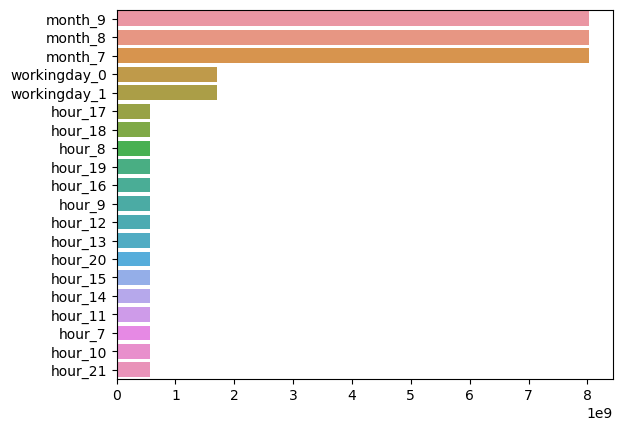

In [47]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

#### 이번에는 회귀 트리를 이용해 회귀 예측을 수행해보자
#### 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가

In [48]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.311, MAE: 31.132
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.333, MAE: 32.739
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


#### 앞의 선형 회귀 모델보다 회귀 예측 성능이 더 개선되었다.
#### 하지만, 반드시 회귀트리가 선형 회귀보다 나은 성능을 가진다는 의미는 아니다! 데이터에 따라 결과는 달라질 수 있다